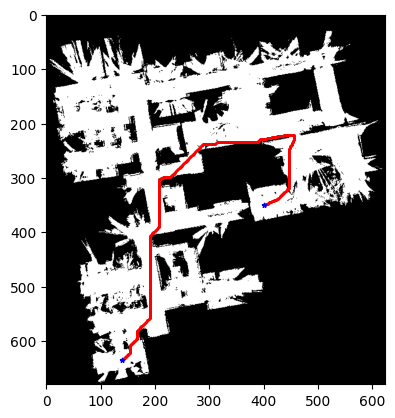

In [12]:
from heapq import heappush, heappop
import numpy as np
from PIL import Image
import itertools
import matplotlib.pyplot as plt


class PriorityQueue:
    # Class made from Python heapq documentation
    REMOVED = "<removed-vertex>"  # placeholder for a removed vertex

    def __init__(self):
        self.pq = []  # list of entries arranged in a heap
        self.entry_finder = {}  # mapping of vertexs to entries
        self.counter = itertools.count()  # unique sequence count

    def add_vertex(self, vertex, priority):
        "Add a new vertex or update the priority of an existing vertex"
        if vertex in self.entry_finder:
            self.remove_vertex(vertex)
        count = next(self.counter)
        entry = [priority, count, vertex]
        self.entry_finder[vertex] = entry
        heappush(self.pq, entry)

    def remove_vertex(self, vertex):
        "Mark an existing vertex as REMOVED.  Raise KeyError if not found."
        entry = self.entry_finder.pop(vertex)
        entry[-1] = PriorityQueue.REMOVED

    def pop_vertex(self):
        "Remove and return the lowest priority vertex. Raise KeyError if empty."
        while self.pq:
            _, _, vertex = heappop(self.pq)
            if vertex is not PriorityQueue.REMOVED:
                del self.entry_finder[vertex]
                return vertex
        raise KeyError("pop from an empty priority queue")


def N(v, M):
    row_start = max(0, v[0] - 1)
    col_start = max(0, v[1] - 1)

    ROI = M[
        row_start : min(M.shape[0] + 1, v[0] + 2),
        col_start : min(M.shape[1] + 1, v[1] + 2),
    ]

    return [(row_start + pt[0], col_start + pt[1]) for pt in np.argwhere(ROI)]


def d(v1, v2):
    return np.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)


def RecoverPath(s, g, pred):
    # start and goal are tuples (r,c), pred is dict
    vertex_curr = g
    opt_path = [g]
    while not vertex_curr == s:
        vertex_curr = pred[vertex_curr]
        opt_path.append(vertex_curr)
        
    return opt_path[::-1]


def a_star_search(V, s, g, N, w, h):
    # N is neighbors function
    # h is estimated cost from s to g
    # w is weight function

    CostTo = {}
    EstTotalCost = {}
    pred = {}
    Q = PriorityQueue()

    CostTo = {v: np.inf for v in np.ndindex(*V.shape)}
    EstTotalCost = CostTo.copy()

    CostTo[s] = 0
    EstTotalCost[s] = h(s, g)

    Q.add_vertex(s, h(s, g))

    while Q.pq:
        v = Q.pop_vertex()
        if v == g:
            return RecoverPath(s, g, pred)

        for i in N(v, V):
            pvi = CostTo[v] + w(v, i)
            if pvi < CostTo[i]:
                pred[i] = v
                CostTo[i] = pvi
                EstTotalCost[i] = pvi + h(i, g)
                Q.add_vertex(i, EstTotalCost[i])

    return None


# Run a*
occupancy_map_img = Image.open("occupancy_map.png")
occupancy_grid = (np.asarray(occupancy_map_img) > 0).astype(int)

s = (635, 140)
g = (350, 400)

shortest_path = a_star_search(occupancy_grid, s, g, N, d, d)
path_to_scatter = np.asarray(shortest_path)

plt.imshow(occupancy_map_img, cmap="gray")
plt.scatter(path_to_scatter[1:-1,1], path_to_scatter[1:-1,0], c='r', s=1)
plt.scatter(path_to_scatter[[0,-1],1], path_to_scatter[[0,-1],0], c='b', s=10, marker="*")
plt.show()
